In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
from cmdstanpy import cmdstan_path, CmdStanModel
from cmdstanpy import CmdStanModel
import cmdstanpy
import json
from tqdm.notebook import tqdm
import seaborn as sns
import os
from IPython.display import display, HTML
import glob


#import arviz as az

import json
import warnings
warnings.filterwarnings('ignore')


## Data parser

Find and download all microrheology data and format dictionary for stan

In [91]:
paths = glob.glob("H:/instru_projects/rheology/microrheology/paper_*/Alg*/*/results/*_ref_*.csv")


df_micro = []

for i in range(len(paths)):
    
    current = paths[i]
    df_tmp = pd.read_csv(current)

    parts = current.split("\\")[2].split("_")
    parts_2 = current.split("\\")[3].split("_")
    parts_3 = current.split("\\")[1].split("_")
    
    df_tmp["material"] = parts_3[1] 
    df_tmp["day"] = parts_2[0]
    df_tmp["size"] = int(parts_2[1][:-2])
    df_tmp["coating"] = parts_2[2]
    df_tmp["type"] = current.split("\\")[2]

    df_tmp["G_mean"] = np.abs(df_tmp["G_abs"].values - 200)

    dfs = []
    for tags, j in df_tmp.groupby(['type','day','holder','location','track_id']):

        dfs.append(j.sort_values(by='G_mean', ascending=False).iloc[:2, :].reset_index())

        if j.shape[0] == 1:
            print(j)

    df_tmp = pd.concat(dfs)



    df_micro.append(df_tmp)

df_micro = pd.concat(df_micro)


   track_id  reference_id  distance(um)   Cov_Sum   a_(um)  phi_(rad)  \
0         0             2    241.043562  0.000056  0.20533    0.22814   

           c         d      G_abs  radius_(m)  ...  holder  location  repeat  \
0  48.825687  0.031788  11.250873    0.000006  ...       1         1       1   

                         type  phi_(deg)   tan_phi  material  size  coating  \
0  AlgVLVG0_0Ca_2mgmlcollagen  13.071443  0.232182  collagen    10    plain   

       G_mean  
0  188.749127  

[1 rows x 31 columns]
    track_id  reference_id  distance(um)   Cov_Sum    a_(um)  phi_(rad)  \
12         7             0    247.093719  0.000036  0.429004   0.202948   

             c         d     G_abs  radius_(m)  ...  holder  location  repeat  \
12 -241.105308 -0.145175  5.489582    0.000006  ...       1         1       1   

                          type  phi_(deg)   tan_phi  material  size  coating  \
12  AlgVLVG0_0Ca_2mgmlcollagen   11.62809  0.205781  collagen    10    plain   

   

In [93]:
df_micro.to_csv("./dataStore/datas_2_ref.csv")

In [3]:
paths = glob.glob("H:/instru_projects/rheology/microrheology/paper_*/Alg*/*/results/*_ID_*.csv")

for i in range(len(paths)):
    
    current = paths[i]
    print(current)
    df_tmp = pd.read_csv(current)
    parts = current.split("\\")[2].split("_")
    parts_2 = current.split("\\")[3].split("_")
    parts_3 = current.split("\\")[1].split("_")
    
    df_tmp["material"] = parts_3[1] 
    df_tmp["day"] = parts_2[0]
    df_tmp["size"] = int(parts_2[1][:-2])
    df_tmp["coating"] = parts_2[2]
    df_tmp["type"] = current.split("\\")[2]

    if i == 0:
        df_micro = df_tmp
    else:
        df_micro = pd.concat((df_micro, df_tmp))



df_micro.to_csv("./dataStore/datas_2.csv")

H:/instru_projects/rheology/microrheology\paper_collagen\AlgVLVG0_0Ca_2mgmlcollagen\211029_10um_plain\results\summary_ID_level.csv
H:/instru_projects/rheology/microrheology\paper_collagen\AlgVLVG0_0Ca_2mgmlcollagen\240325_10um_plain\results\summary_ID_level.csv
H:/instru_projects/rheology/microrheology\paper_collagen\AlgVLVG0_0Ca_2mgmlcollagen\240326_10um_plain\results\summary_ID_level.csv
H:/instru_projects/rheology/microrheology\paper_collagen\AlgVLVG0_0Ca_2mgmlcollagen\240620_30um_NH2\results\summary_ID_level.csv
H:/instru_projects/rheology/microrheology\paper_collagen\AlgVLVG0_0Ca_2mgmlcollagen\240820_30um_COOH\results\summary_ID_level.csv
H:/instru_projects/rheology/microrheology\paper_IPN\AlgLVLG15_3Ca_2mgmlcollagen\230728_10um_plain\results\summary_ID_level.csv
H:/instru_projects/rheology/microrheology\paper_IPN\AlgLVLG15_3Ca_2mgmlcollagen\230814_10um_plain\results\summary_ID_level.csv
H:/instru_projects/rheology/microrheology\paper_IPN\AlgLVLG15_3Ca_2mgmlcollagen\230815_10um_pl

In [4]:
# Download data and make a mega .csv fiel

paths=[]
paths = glob.glob(os.path.join('C:/Users/srboval1/IPN15/AlgVLVG15_3Ca/*','**','summary_ref_level.csv'))
print(paths)
concentration = '3/2'
type ='IPN_soft'

a = []
for i in paths:
    path1 = os.path.split(os.path.split(i)[0])[0]
    path1.replace("/","\\")
    splitted= path1.split('\\')[-1]
    tmp = pd.read_csv(i)
    tmp['coating_type'] = splitted.split('_')[-1]
    tmp['size'] = splitted.split('_')[-2]
    tmp['day'] = splitted.split('_')[-4]
    a.append(tmp)

a_concantenated=[]
a_concantenated = pd.concat(a)
a_concantenated['radius_(m)'] *= 1e6
a_concantenated = a_concantenated.rename(columns={'radius_(m)':'radius_(um)'})
a_concantenated['concentration'] = concentration
a_concantenated['type'] = type
a_concantenated['frequency'] = 0.05
a_concantenated = a_concantenated.reindex(columns=['day','frequency','concentration','type','sample','holder','location','repeat','track_id','reference_id','distance(um)','Cov_Sum','a_(um)','phi_(rad)','c','d','G_abs','radius_(m)','r2','rmse','inv.rmse','shift_(s)','a_error','phi_error','c_error','d_error','x','y','phi_(deg)','tan_phi'])
print(a_concantenated)
#%%
if os.path.exists('C:/Users/srboval1/IPN15/IPN15.csv'):
    a_new = pd.DataFrame(a_concantenated)
    a_new.to_csv('C:/Users/srboval1/IPN15/IPN15.csv', mode='a', index=False, header=False)
else:
    a_concantenated.to_csv("C:/Users/srboval1/IPN15/IPN15.csv", index=False)
    

[]


ValueError: No objects to concatenate

In [89]:
data_all = pd.read_csv('./dataStore/datas_2_ref.csv')

#mask = data_all["size"]== '3'
#data_all["size"] = 10
#data_all.loc[mask, "size"] = 30

#for j in range(data_all.shape[0]):
#    data_all.loc[j, "type"] = "{}_{}".format(data_all["type"][j],data_all["concentration"][j])

#calculating G std for each material typeand then choosing the highest one of all
G_std = (np.max(data_all[['type','day','holder','location','track_id','reference_id',"G_abs", "phi_(deg)"]].groupby(["type"]).std()["G_abs"].values))
print(G_std)

#calculating G std for each material type and then choosing the highest one of all
phi_std = np.max(data_all[['type','day','holder','location','track_id','reference_id',"G_abs", "phi_(deg)"]].groupby(["type"]).std()["phi_(deg)"].values)
print(phi_std)


full_path = os.path.split(os.getcwd())[0]
print(["G_abs", "phi_(rad)"], "\n",data_all["type"].unique())

#data_all[data_all["type"] == "IPN_AlgVLVG15_40Ca_2mgmlcollagen"]["size"] = 100

1882.6222585031169
15.3433620664305
['G_abs', 'phi_(rad)'] 
 ['AlgVLVG0_0Ca_2mgmlcollagen' 'AlgLVLG15_3Ca_2mgmlcollagen'
 'AlgVLVG15_22Ca_2mgmlcollagen' 'AlgVLVG15_40Ca_2mgmlcollagen']


In [111]:
df_temp = data_all.groupby(["type", "day", "sample", "holder"]).count()[["track_id"]].reset_index(drop=False)
df_temp.values

array([['AlgLVLG15_3Ca_2mgmlcollagen', 230728, 1, 1, 2],
       ['AlgLVLG15_3Ca_2mgmlcollagen', 230814, 1, 2, 1],
       ['AlgLVLG15_3Ca_2mgmlcollagen', 230814, 1, 3, 1],
       ['AlgLVLG15_3Ca_2mgmlcollagen', 230815, 1, 1, 2],
       ['AlgLVLG15_3Ca_2mgmlcollagen', 240827, 1, 2, 2],
       ['AlgLVLG15_3Ca_2mgmlcollagen', 240828, 1, 1, 2],
       ['AlgVLVG0_0Ca_2mgmlcollagen', 211029, 10, 10, 2],
       ['AlgVLVG0_0Ca_2mgmlcollagen', 240325, 1, 1, 2],
       ['AlgVLVG0_0Ca_2mgmlcollagen', 240326, 1, 4, 2],
       ['AlgVLVG0_0Ca_2mgmlcollagen', 240620, 1, 1, 1],
       ['AlgVLVG0_0Ca_2mgmlcollagen', 240620, 1, 2, 1],
       ['AlgVLVG0_0Ca_2mgmlcollagen', 240820, 1, 1, 1],
       ['AlgVLVG0_0Ca_2mgmlcollagen', 240820, 1, 2, 1],
       ['AlgVLVG15_22Ca_2mgmlcollagen', 240616, 3, 3, 2],
       ['AlgVLVG15_22Ca_2mgmlcollagen', 240617, 1, 1, 1],
       ['AlgVLVG15_22Ca_2mgmlcollagen', 240617, 1, 2, 1],
       ['AlgVLVG15_22Ca_2mgmlcollagen', 240618, 2, 2, 1],
       ['AlgVLVG15_22Ca_2mgmlcol

In [112]:
for type_, day, sample,holder, vals in df_temp[df_temp["track_id"]==1].values:
    print(type_, day, holder, vals)
    i = data_all[((data_all.type == type_) &( data_all.day == day)&( data_all.sample == sample) & (data_all.holder == holder))].index
    print(i )
    data_all = data_all.drop(i)

i = data_all[((data_all.type == "AlgVLVG0_0Ca_2mgmlcollagen") &( data_all.day == "211029") & (data_all.sample == 1))].index
print(i )
data_all = data_all.drop(i)
data_all = data_all.reset_index(drop=True)

AlgLVLG15_3Ca_2mgmlcollagen 230814 2 1
Index([], dtype='int64')
AlgLVLG15_3Ca_2mgmlcollagen 230814 3 1
Index([], dtype='int64')
AlgVLVG0_0Ca_2mgmlcollagen 240620 1 1
Index([], dtype='int64')
AlgVLVG0_0Ca_2mgmlcollagen 240620 2 1
Index([], dtype='int64')
AlgVLVG0_0Ca_2mgmlcollagen 240820 1 1
Index([], dtype='int64')
AlgVLVG0_0Ca_2mgmlcollagen 240820 2 1
Index([], dtype='int64')
AlgVLVG15_22Ca_2mgmlcollagen 240617 1 1
Index([], dtype='int64')
AlgVLVG15_22Ca_2mgmlcollagen 240617 2 1
Index([], dtype='int64')
AlgVLVG15_22Ca_2mgmlcollagen 240618 2 1
Index([], dtype='int64')
AlgVLVG15_22Ca_2mgmlcollagen 240618 3 1
Index([], dtype='int64')
AlgVLVG15_22Ca_2mgmlcollagen 240820 2 1
Index([], dtype='int64')
AlgVLVG15_22Ca_2mgmlcollagen 240820 3 1
Index([], dtype='int64')
AlgVLVG15_40Ca_2mgmlcollagen 240703 2 1
Index([], dtype='int64')
AlgVLVG15_40Ca_2mgmlcollagen 240703 3 1
Index([], dtype='int64')
Index([], dtype='int64')


This python code which includes model definition, which itself is written in Stan language, while Python is used to preprocess data, compile the model, run inference, and analyze results.

1. Creating a dictionary from the collected data - preprocessing
2. Compiling the model, sampling it on the data
3. Interference and analysis - fitting

In [113]:
def pred(model_name,data_all,diagnose=False):
    """Preprocess data and fit model
        model_name: name of the stan model e.g hier_material (no .stan)
        diagnoise: print mcmc diagnostics, rhat...
        returns: tuple of two dicts where
         keys are G_abs and phi_(deg)
                first containts the mcmc samples as pandas dataframe
                secods contains arviz datastructure for visualizations
    """
    out = {}
    az_out = {}

    # process mechanical properties separately
    for g_a in ['G_abs']: #,'phi_(deg)'
        samples = []
        out[g_a] = {}
        # combine information of all materials
        for ss in data_all["type"].unique(): 
            print(ss)
            data_type = ss
            data = data_all[data_all['type']==data_type]

            sample_num = []
            prev = None
            idx = 1
            for i in data['day']:
                if prev is None:
                    prev = i
                if prev != i:
                    idx += 1
                    prev = i
                sample_num.append(idx)

            data['sample_num'] = sample_num

            subset = data[['sample_num','holder','location','track_id',g_a]]
            subset['sample_num'] = subset['sample_num'].astype(int)
            sample_ids = []
            location_ids = []
            holder_ids = []
            track_ids = []
            n_loc = 0
            n_hold = 0
            n_samp = 0
            # we want consecutive numbering
            for i in subset['sample_num'].unique():
                sub_sample = subset[subset['sample_num']==i]
                sample_ids.extend([int(i)]*sub_sample['holder'].unique().shape[0])

                for jj,j in enumerate(sub_sample['holder'].unique()):
                    sub = sub_sample[sub_sample['holder']==j]
                    holder_ids.extend([int(jj+1)+n_samp]*sub['location'].unique().shape[0])

                    for kk,k in enumerate(sub['location'].unique()):
                        sub2 = sub[sub['location']==k]
                        location_ids.extend([int(kk+1)+n_hold]*sub2['track_id'].unique().shape[0])

                        for zz,z in enumerate(sub2['track_id'].unique()):
                            sub3 = sub2[sub2['track_id']==z]
                            track_ids.extend([int(zz+1)+n_loc]*sub3.shape[0])


                        n_loc += int(sub2['track_id'].unique().shape[0])
                    n_hold += int(sub['location'].unique().shape[0])
                n_samp += int(sub_sample['holder'].unique().shape[0])
                
            # normalize mean to zero and with common std
            y_raw = subset[g_a].values
            #y_raw = y_raw-np.mean(y_raw)
            if g_a == 'G_abs':
                y = y_raw/G_std
            else:
                y = y_raw/phi_std

            y = np.log(y)    
            #y = (y_raw-np.mean(y_raw))/(np.std(y_raw))
            sample = {'N':subset.shape[0],
                      'N_samples':int(np.max(sample_ids)),
                      'N_holders': int(np.max(holder_ids)),
                      'N_locations': int(np.max(location_ids)),
                      'N_ids':int(np.max(track_ids)),
                      'sample_ids':sample_ids,
                      'holder_ids':holder_ids,
                      'location_ids':location_ids,
                      'track_ids':track_ids,
                      'train_ids':(np.arange(len(track_ids))+1).tolist(),
                      'N_train': subset.shape[0],
                      'y':y.tolist()}

            samples.append(sample.copy())

        # combine different materials into a single dict/json for stan
        combined = samples[0]

        combined['material_ids'] = np.ones(combined['N_samples'],dtype=int).tolist()
        combined['material_sigma_ids'] = np.ones(combined['N'],dtype=int).tolist()

        s_max = combined['N_samples']
        h_max = combined['N_holders']
        l_max = combined['N_locations']
        t_max = combined['N_ids']
        m_max = 1
        for s in samples[1:]:
            #print(s['N'])
            combined['N'] += s['N']
            combined['N_samples'] += s['N_samples']
            combined['N_holders'] += s['N_holders']
            combined['N_locations'] += s['N_locations']
            combined['N_ids'] += s['N_ids']
            combined['sample_ids'].extend((np.array(s['sample_ids'])+s_max).tolist())
            combined['holder_ids'].extend((np.array(s['holder_ids'])+h_max).tolist())
            combined['location_ids'].extend((np.array(s['location_ids'])+l_max).tolist())
            combined['track_ids'].extend((np.array(s['track_ids'])+t_max).tolist())

            combined['y'].extend(s['y'])
            
            combined['material_ids'].extend((np.ones(s['N_samples'],dtype=int)+m_max).tolist())
            combined['material_sigma_ids'].extend((np.ones(s['N'],dtype=int)+m_max).tolist())

            s_max += s['N_samples']
            h_max += s['N_holders']
            l_max += s['N_locations']
            t_max += s['N_ids']
            m_max += 1

        combined['train_ids'] = ((np.arange(combined['N'])+1).astype(int)).tolist()
        combined['N_train'] = len(combined['train_ids'])

        combined['sample_ids'] = combined['sample_ids']
        combined['holder_ids'] = combined['holder_ids']
        combined['location_ids'] = combined['location_ids']
        combined['track_ids'] = combined['track_ids']

        combined['material_ids'] = np.array(combined['material_ids']).astype(int).tolist()
        combined['material_sigma_ids'] = np.array(combined['material_sigma_ids']).astype(int).tolist()

        combined['N_materials'] = len(samples)

        radius_indices = np.zeros(data_all.shape[0],dtype=int)
        radius_orig = np.zeros(data_all.shape[0],dtype=object)

        for idx,i in enumerate(np.unique(data_all["size"])):
            mask = data_all["size"] == i
            radius_indices[mask] = idx+1
            radius_orig[mask] = i

        
        #combined['radius_ids']= radius_indices.tolist()
        print(combined.keys())
        json_path = os.path.join("./dataStore/datas.json")
        with open(json_path,'w') as f:
            json.dump(combined,f)

    return combined, az_out, out

In [21]:
#function preprocessing data and fitting model
#model_name: name of the stan model e.g hier_material (no .stan)
#diagnoise: print mcmc diagnostics, rhat...
#returns: tuple of two dicts where keys are G_abs and phi_(deg)
#first containts the mcmc samples as pandas dataframe
#seconds contains arviz datastructure for visualizations
def preprocessing(model_name, data_all, diagnose = True):
        
    out = {}
    az_out = {}

    #process G and phi measurements separately, 
    for measurement in ['G_abs']: #G_abs
        samples = []
        out[measurement] = {}

        #combine information of all materials
        #looping through each material one by one
        for material in data_all["type"].unique():
            data_type = material
            data = data_all[data_all['type'] == data_type]

            #initializing empty list that will contain corresponding numbers for each sample
            sample_num = []
        
            prev = None
            idx = 1
            #assuming one sample per day, adding sample ids to the list in sample_num
            #iterating over each element in the 'day' column of data and creating the sample_num list
            for i in data['day']:
                if prev is None:
                    prev = i
                else: #changed from Ossi's code 'if' - to have distinct sample ids
                    idx += 1
                    prev = i
                sample_num.append(idx)      
            
            data['sample_num'] = sample_num
            subset = data [['sample_num','holder','location', 'track_id', measurement, "type"]]
            subset['sample_num']=subset['sample_num'].astype(int) #convertin sample numbers to integers
            
            sample_ids=[]
            location_ids=[]
            holder_ids=[]
            track_ids=[]

            #return radius_indices, radius_orig
            n_loc = 0       #initial number of ids in locations
            n_hold = 0      #initial locations in holders
            n_samp = 0    #initial holders in samples

        #change into consecutive numbering
            for i in subset['sample_num'].unique():             
                sub_sample = subset[subset['sample_num']==i]        #new df containing only the rows (measurements) with that unique sample_num i
                sample_ids.extend([int(i)]*sub_sample['holder'].unique().shape[0])
                for jj,j in enumerate(sub_sample['holder'].unique()):
                    sub = sub_sample[sub_sample['holder']==j]
                    holder_ids.extend([int(jj+1)+n_samp]*sub['location'].unique().shape[0]) #list that will eventually be listing all holder ids for each location - add identity number of holder times the number of locations (unique holder numbers)
                    for kk,k in enumerate(sub['location'].unique()):
                        sub2 = sub[sub['location']==k]
                        location_ids.extend([int(kk+1)+n_hold]*sub2['track_id'].unique().shape[0])
                        for zz, z in enumerate(sub2['track_id'].unique()):
                            sub3 = sub2[sub2['track_id']==z]
                            track_ids.extend([int(zz+1)+n_loc]*sub3.shape[0]) #shape[0] size of the first dimension = row
                        n_loc += int(sub2['track_id'].unique().shape[0])    #number of tracks ids that have been looped through already; updated with each location
                    n_hold += int(sub['location'].unique().shape[0])    #number of locations that have been looped through; used to add up in the next holder
                n_samp += int(sub_sample['holder'].unique().shape[0])   #number of holders that have been looped through; used to add up in the next sample

            # normalize mean to zero and with common std 
            y_raw = subset[measurement].values  #retrieves values of the column labelled measurement from df subset and converts into array by .value
            if measurement == 'G_abs':          #compares measurement to a fixed string 'G_abs' variable
                y = (y_raw-np.mean(y_raw))/G_std                 #each value scaled by std
            else:
                y = (y_raw-np.mean(y_raw))/phi_std

            radius_indices = np.zeros(subset.shape[0],dtype=int)
            radius_orig = np.zeros(subset.shape[0],dtype=object)

            for idx,i in enumerate(np.unique(subset["type"])):
                mask = subset["type"] == i
                radius_indices[mask] = idx+1
                radius_orig[mask] = i

            #defining dictionary; curly brackets and specified key-value pairs separated by : each key corresponds to a specific attribute }
            sample = {      'N'         :subset.shape[0],
                            'N_samples' : int(np.max(sample_ids)),
                            'N_holders' : int(np.max(holder_ids)),
                            'N_locations':int(np.max(location_ids)),
                            'N_ids'     : int(np.max(track_ids)),
                            'sample_ids': sample_ids,
                            'holder_ids': holder_ids,
                            'location_ids':location_ids,
                            'track_ids':  track_ids,
                            'train_ids':  (np.arange(len(track_ids))+1).tolist(),
                            'radius_ids': radius_indices.tolist(), 
                            'N_train':    subset.shape[0],
                            'y':          y.tolist()}
            
            #appending a shallow copy 'samples' of sample - doesn't create copies of the objects it references to
            samples.append(sample.copy())

    # combine different materials into a single dict/json for stan
    combined = samples[0]           #combined is assigned the value of the first element (samples[0]) from the list samples
    combined['material_ids'] = np.ones(combined['N_samples'],dtype=int).tolist() #creates a list of ones with a length determined by the value of 'N_samples'
    s_max = combined['N_samples']
    h_max = combined['N_holders']
    l_max = combined['N_locations']
    t_max = combined['N_ids']
    m_max = 1

    for s in samples[1:]:       #code iterates over all elements in the samples list except the first one
        #print(s['N'])
        combined['N'] += s['N'] #accesses the value associated with the key 'N' in the dictionary combined and incrementing it by the value associated with the key 'N' in each dictionary s in the samples list
        combined['N_samples'] += s['N_samples']
        combined['N_holders'] += s['N_holders']
        combined['N_locations'] += s['N_locations']
        combined['N_ids'] += s['N_ids']
        combined['sample_ids'].extend((np.array(s['sample_ids'])+s_max).tolist())
        combined['holder_ids'].extend((np.array(s['holder_ids'])+h_max).tolist())
        combined['location_ids'].extend((np.array(s['location_ids'])+l_max).tolist())
        combined['track_ids'].extend((np.array(s['track_ids'])+t_max).tolist())
        combined['y'].extend(s['y'])
        combined['material_ids'].extend((np.ones(s['N_samples'],dtype=int)+m_max).tolist())

        s_max += s['N_samples']
        h_max += s['N_holders']
        l_max += s['N_locations']
        t_max += s['N_ids']
        m_max += 1

    combined['train_ids'] = ((np.arange(combined['N'])+1).astype(int)).tolist()
    combined['N_train'] = len(combined['train_ids'])
    combined['sample_ids'] = combined['sample_ids']
    combined['holder_ids'] = combined['holder_ids']
    combined['location_ids'] = combined['location_ids']
    combined['track_ids'] = combined['track_ids']
    combined['material_ids'] = np.array(combined['material_ids']).astype(int).tolist()
    combined['N_materials'] = len(samples)


    #crating path to which the dictionary is saved in json format
    
    file_path = os.path.join("./dataStore/datas.json")

    # Writing the dictionary to a JSON file
    with open(file_path, "w") as json_file:
        json.dump(combined, json_file)

    # Stan model = math of the Bayesian model
    # function CmdStanModel is used to compile the file with Stan model, e.g. converting it into a format that can be executed by the CmdStan command-line tool.
    #stan_model_path =  'C:/Users/lehtona6/codes/InstruProject/microrheology/models/model_Linda_size_factor.stan'
    stan_model_path =  "C:/Users/lehto/git/InstruProject/microrheology/models/model_Linda_size_factor.stan"
    

    model = CmdStanModel(stan_file=stan_model_path)
    

    # Bayes model: all the available data is used to estimate the parameters of the model
    # and the posterior distribution which is then used for inference and analysis


    #Using sample method of CmdStanModel
    # sampling (all) data from the file path by Hamiltonian Monte Carlo (HMC) algorithm
    # to generate samples from the posterior distribution of the model parameters
    # high adaptation value means adaptation phase is not too aggressive
    # maximum depth of the binary tree used by the algorithm - controls the complexity of the trajectories explored by the sampler
    fit = model.sample(data=file_path, show_console=True)
                            #adapt_delta=0.9999999999999999,max_treedepth=20,iter_sampling=2000)
    if diagnose:
        print(fit.diagnose())

    #converting the sampled data from fit into an ArviZ InferenceData object
    #ArviZ (az) library allows exploratory analysis of Bayesian models
    #object is created from the CmdStanPy object and contains posterior samples, posterior predictive samples, log likelihood, and observed data.
    az_data = az.from_cmdstanpy(posterior=fit,
                                posterior_predictive='y_hat',
                                log_likelihood='log_likelihood',
                                observed_data={'y':combined['y']})
    
    #returns the sampled data obtained from the Bayesian model's sampling output in a pandas DataFrame format in a dictionary
    #basic data manipulation and analysis using pandas functionalities
    out[measurement] = fit.draws_pd()

    #additional functionalities specific to Bayesian analysis
    #posterior predictive checks, convergence diagnostics, and visualization tools, through the ArviZ library.
    az_out[measurement] = az_data
    
    return out,az_out

In [114]:
combined, az_out, out = pred("model_Linda.stan",data_all, True)

AlgVLVG0_0Ca_2mgmlcollagen
AlgLVLG15_3Ca_2mgmlcollagen
AlgVLVG15_22Ca_2mgmlcollagen
AlgVLVG15_40Ca_2mgmlcollagen
dict_keys(['N', 'N_samples', 'N_holders', 'N_locations', 'N_ids', 'sample_ids', 'holder_ids', 'location_ids', 'track_ids', 'train_ids', 'N_train', 'y', 'material_ids', 'material_sigma_ids', 'N_materials'])


In [120]:
stan_model_path = "C:/Users/lehto/git/InstruProject/microrheology/models/model_Linda_error.stan"
model4 = CmdStanModel(stan_file=stan_model_path) #, force_compile=True

fit4 = model4.sample(data="./dataStore/datas.json", show_console=False, adapt_delta=0.999, max_treedepth=20)#, adapt_delta=0.9999999999999999,max_treedepth=20,iter_sampling=2000)
                    #)

az_data4 = az.from_cmdstanpy(posterior=fit4,
                        posterior_predictive='y_hat',
                        log_likelihood='log_likelihood',
                        observed_data={'y':combined['y']})

out['G_abs'] = fit4.draws_pd()
az_out['G_abs'] = az_data4

15:27:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:28:18 - cmdstanpy - INFO - CmdStan done processing.
15:28:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_gamma_lpdf: Shape parameter is inf, but must be positive finite! (in 'model_Linda_error.stan', line 60, column 2 to column 53)
Exception: inv_gamma_lpdf: Shape parameter is inf, but must be positive finite! (in 'model_Linda_error.stan', line 60, column 2 to column 53)
Exception: inv_gamma_lpdf: Shape parameter is inf, but must be positive finite! (in 'model_Linda_error.stan', line 60, column 2 to column 53)
Exception: inv_gamma_lpdf: Shape parameter is inf, but must be positive finite! (in 'model_Linda_error.stan', line 60, column 2 to column 53)
Consider re-running with show_console=True if the above output is unclear!
15:28:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [121]:
print(fit4.diagnose())

Processing csv files: C:\Users\lehto\AppData\Local\Temp\tmp3a28m8af\model_Linda_error_d1mtgii\model_Linda_error-20240906152739_1.csv, C:\Users\lehto\AppData\Local\Temp\tmp3a28m8af\model_Linda_error_d1mtgii\model_Linda_error-20240906152739_2.csv, C:\Users\lehto\AppData\Local\Temp\tmp3a28m8af\model_Linda_error_d1mtgii\model_Linda_error-20240906152739_3.csv, C:\Users\lehto\AppData\Local\Temp\tmp3a28m8af\model_Linda_error_d1mtgii\model_Linda_error-20240906152739_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 4000 (0.03%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.25, is below the nominal threshold of 0.30 which sugg

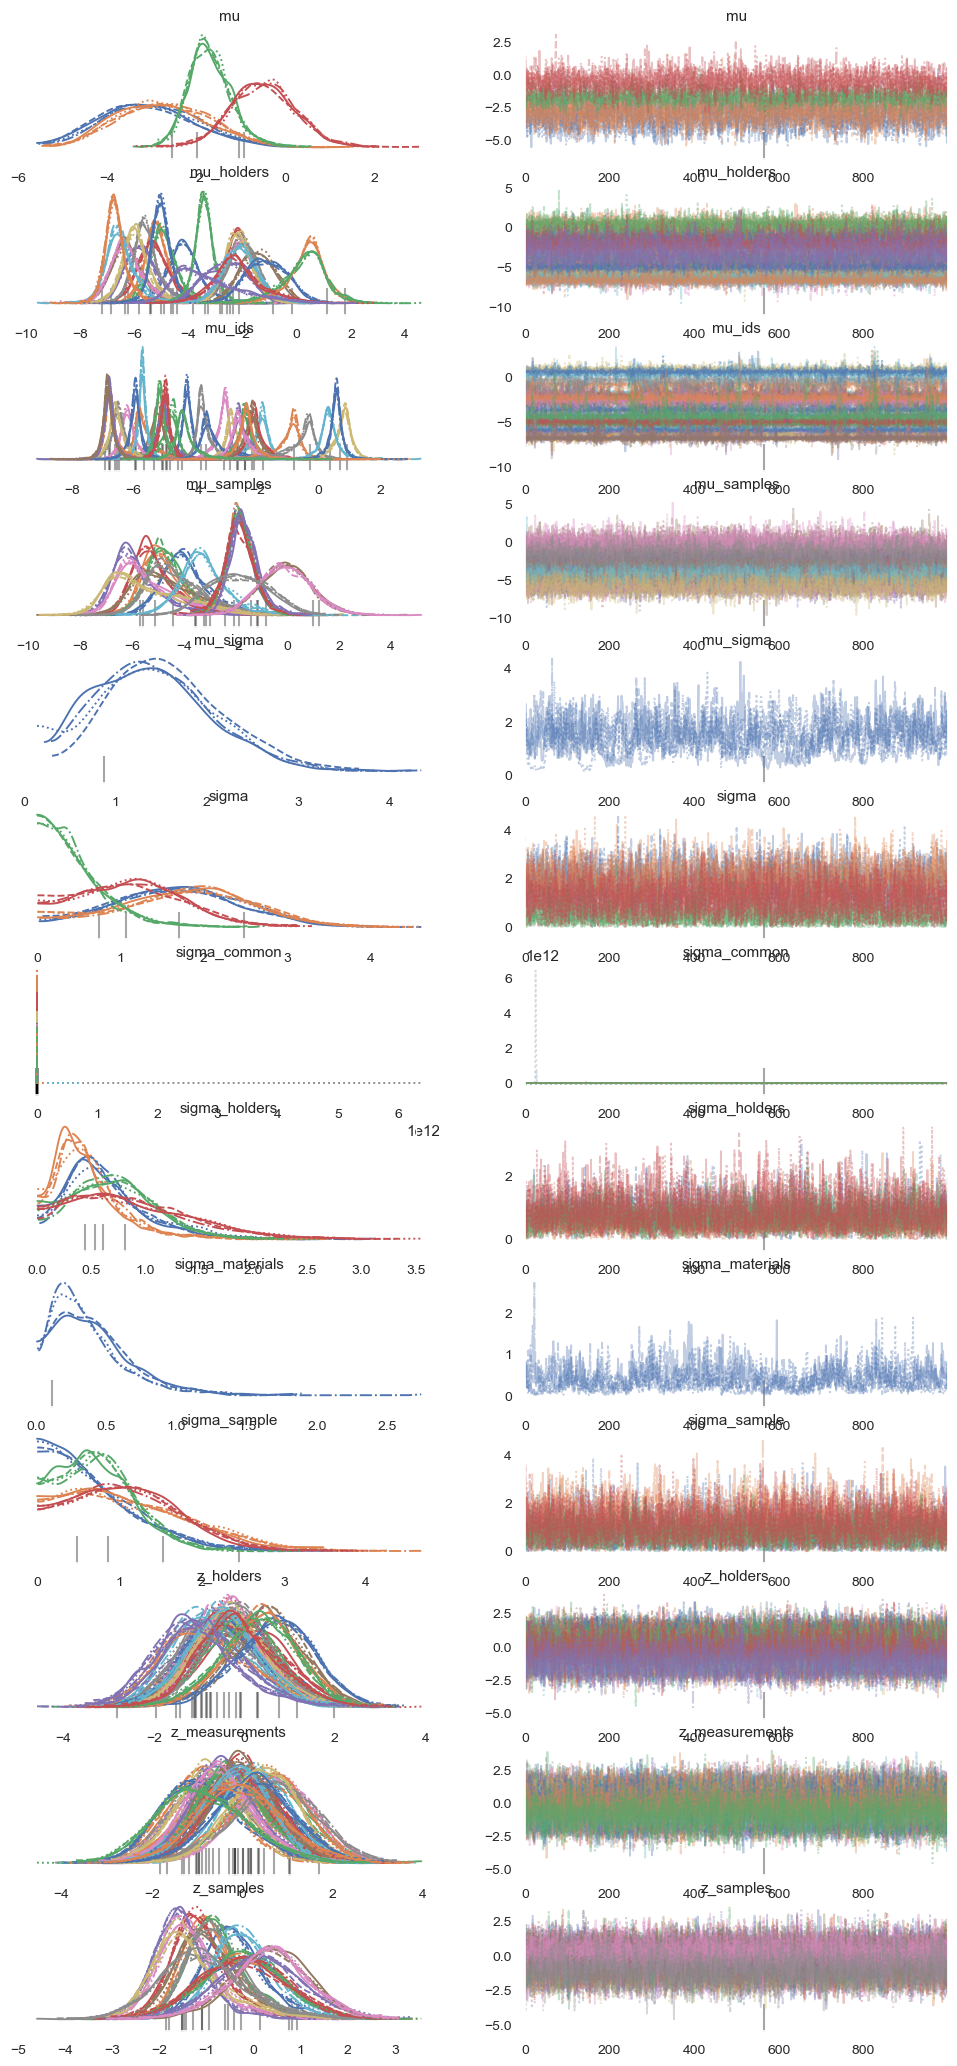

In [122]:
_ = az.plot_trace(az_out["G_abs"])


<Axes: xlabel='y / y_hat'>

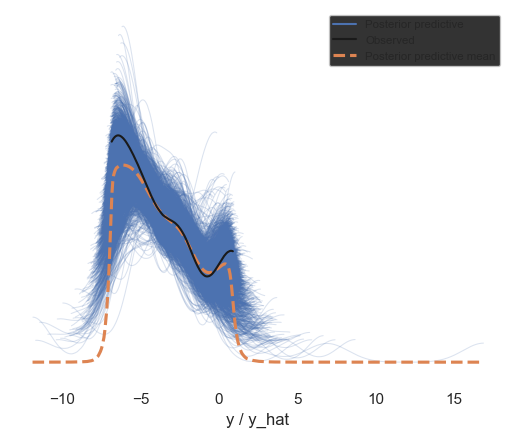

In [123]:
az.plot_ppc(az_out["G_abs"],data_pairs={"y": "y_hat"})
#plt.xlim([-2,2])

In [9]:
az.to_netcdf(az_out["G_abs"], "./dataStore/az_out.nc")
az_out = {}
az_out["G_abs"] = az.from_netcdf("./dataStore/az_out.nc")

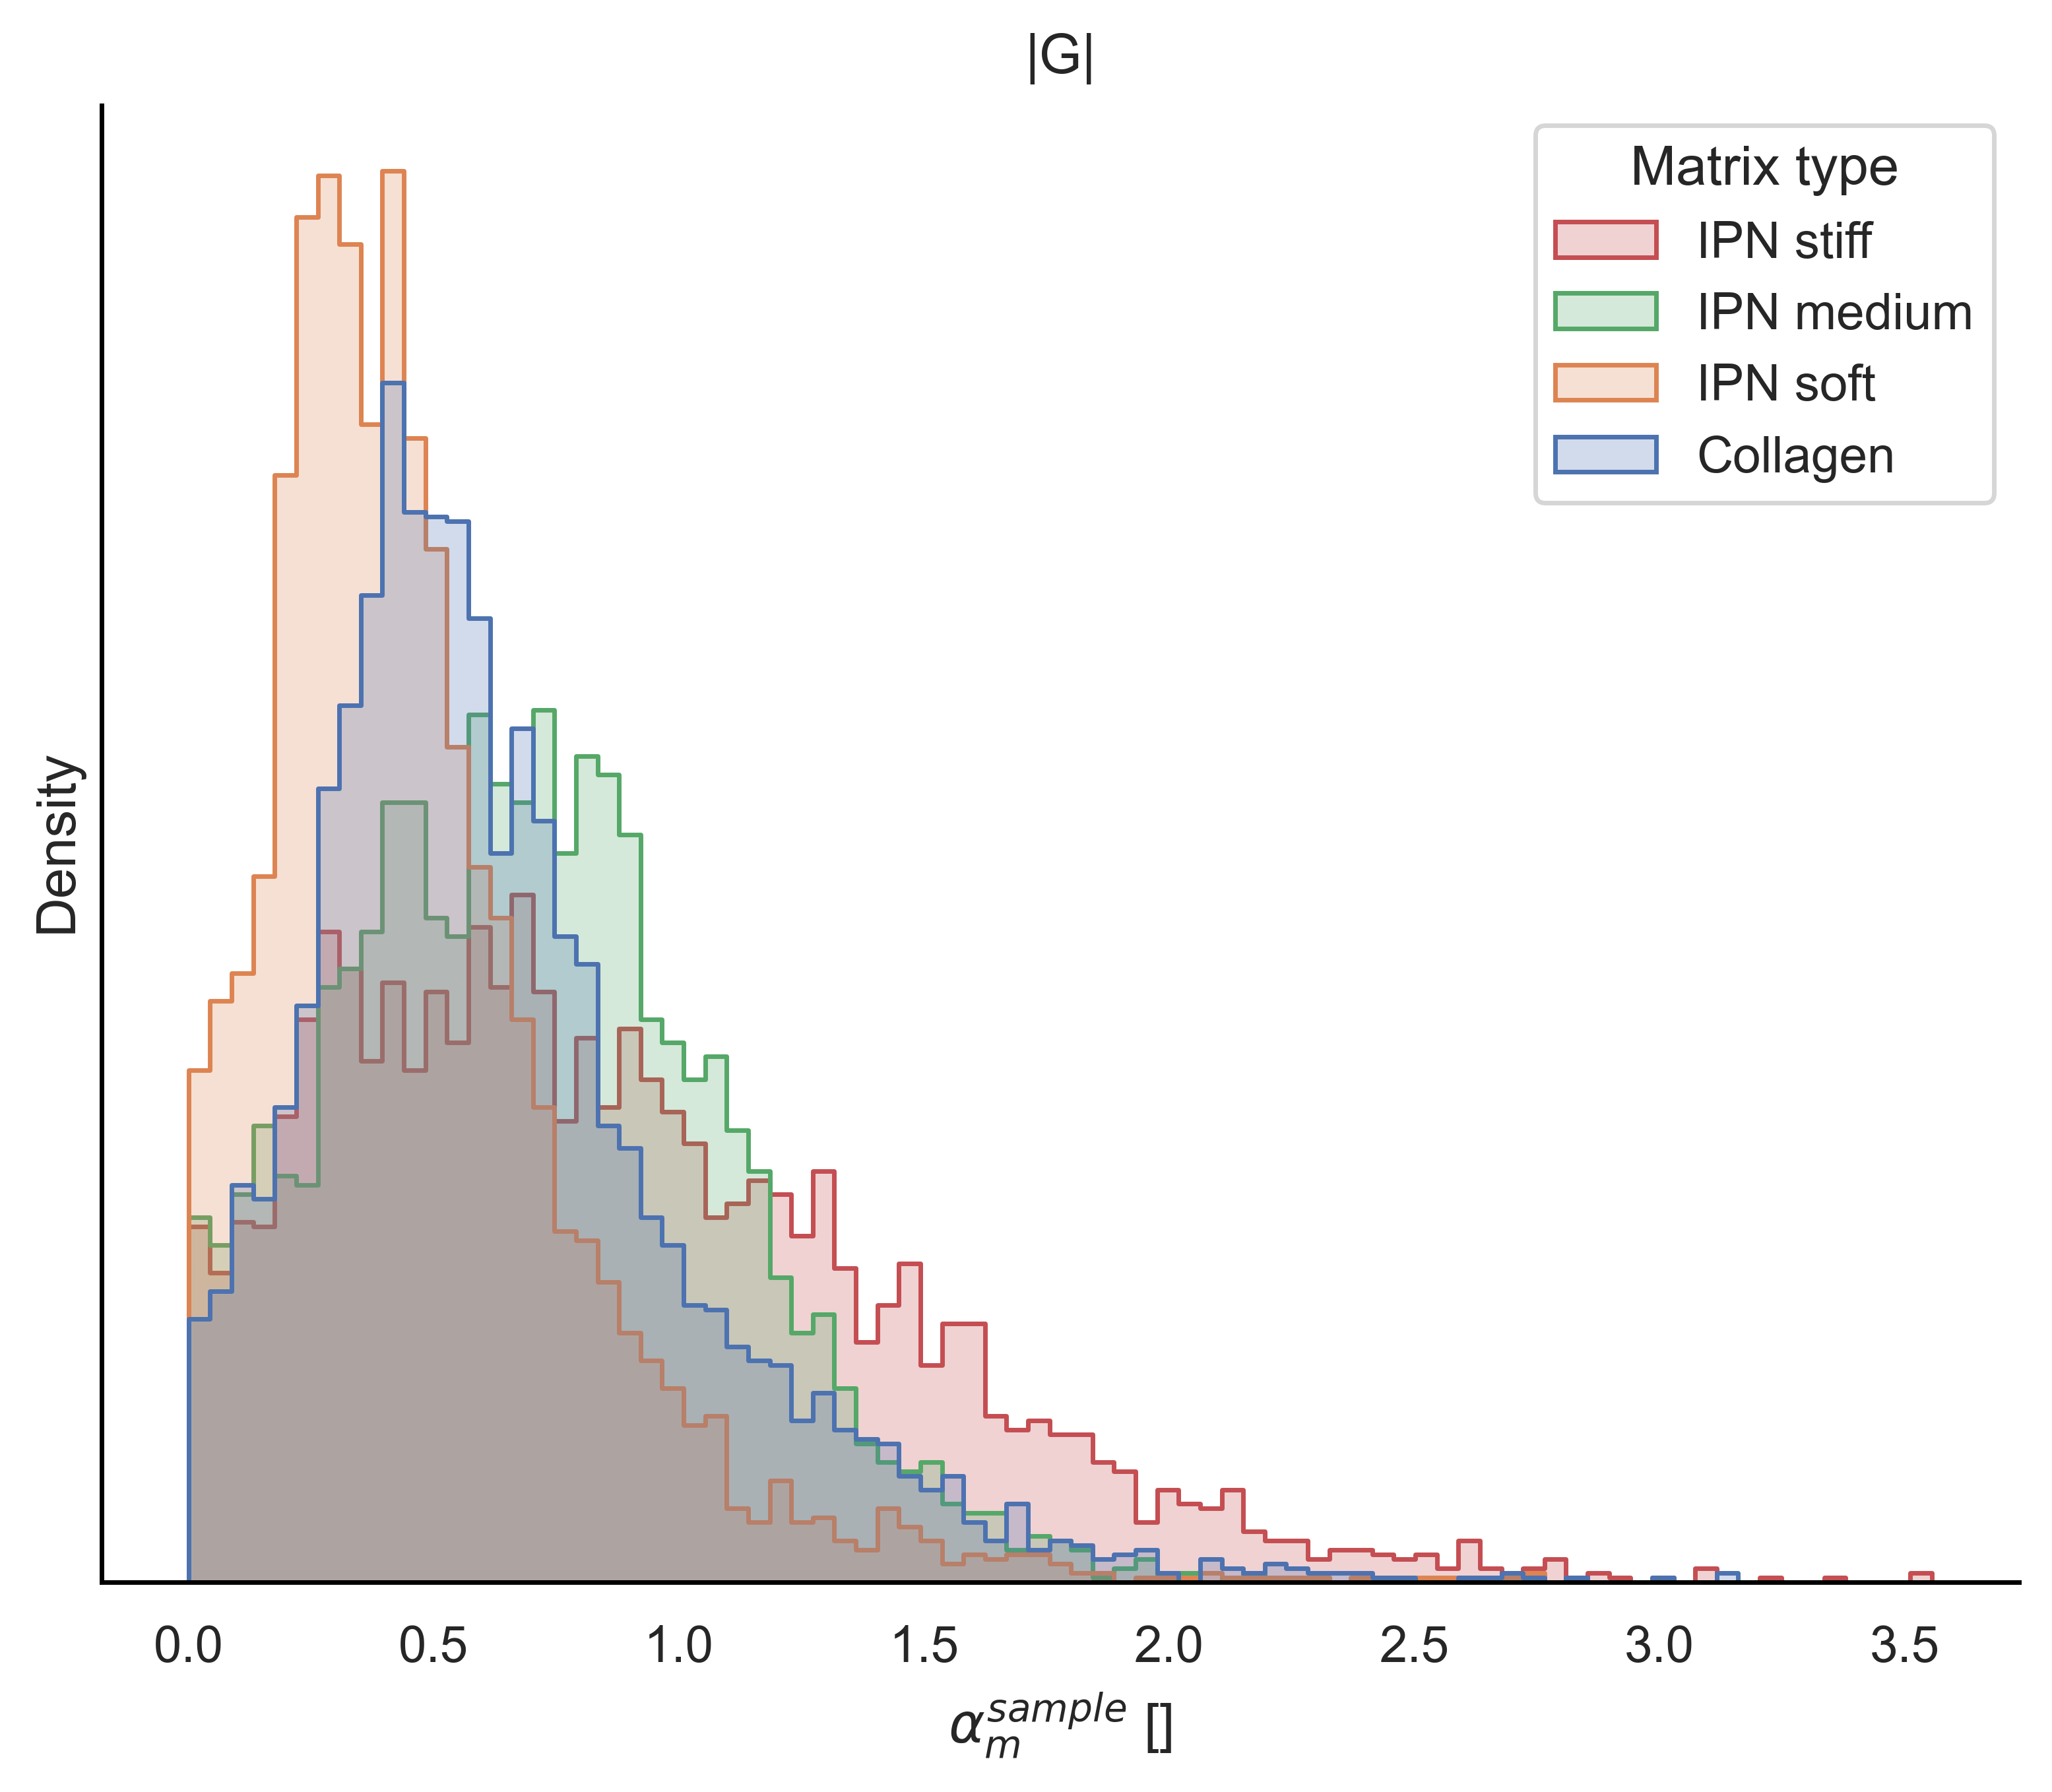

In [124]:
sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0),"legend.facecolor":(0, 0, 0, 1),'axes.grid':True})

def plot_sample_variation(name,ax, hh):

    sample_variations = hh["G_abs"].filter(regex='^sigma_holder')
    sample_variations.columns = ['IPN stiff', 'IPN medium' ,'IPN soft','Collagen' ] 
    # same color,material pairs as in the heterogeneity plot
    sample_variations = sample_variations.iloc[:,[0,1,2,3]]
    sample_variations_melt = sample_variations.melt()

    sns.histplot(data=sample_variations_melt,x='value',hue='variable',ax=ax,
                 element="step",stat='density',discrete=False)

    #ax.set_xlim([0,1.4])
    ax.set_yticks([])
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.set_xlabel(r'$\alpha^{sample}_m$ []')



fig,ax = plt.subplots(1,1,figsize=(7.5,8.75/1.5),dpi=500)

sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0),"legend.facecolor":(0, 0, 0, 1),'axes.grid':True})

plot_sample_variation('G_abs', ax, out)

labs = ['IPN stiff', 'IPN medium' ,'IPN soft','Collagen' ] 

legend = ax.legend(title='Matrix type', loc='upper right',
             labels=labs,
             facecolor='white')

#ax[1].set_ylabel('')
#ax.get_legend().remove()
ax.set_title('|G|')
#ax.set_title(r'$\phi$')

f_s = 20
#ax.text(-0.04, 1.15, 'A', transform=ax.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
#ax.text(-0.04, 1.15, 'B', transform=ax.transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')


In [58]:
data_all.type.unique()

array(['AlgVLVG0_0Ca_2mgmlcollagen', 'AlgLVLG15_3Ca_2mgmlcollagen',
       'AlgVLVG15_22Ca_2mgmlcollagen', 'AlgVLVG15_40Ca_2mgmlcollagen'],
      dtype=object)